In [1]:
import os

os.environ["CONFIG_PATH"] = "/home/locnt7"

os.environ["SPARK_SERVER"] = "SPARK@95"

In [69]:
import datetime as dt
import gc
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats as st
from pdp.core import hdfs_utils, spark_utils
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
from typing import List
import numpy as np
from datetime import timedelta,datetime,date
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,f1_score,precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
%matplotlib inline


def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [3]:
from pdp.core import spark_utils,hdfs_utils
from pyspark.sql import functions as F

import datetime as dt
NO_CORES=8
spark = spark_utils.get_spark_session(
    app_name="recommendation transaction data",
    cores=NO_CORES,
    driver_memory=32,
    executor_memory=32,
    ui_port=9696,
    log_level="ERROR",
)

22/11/21 14:45:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Master: spark://10.60.37.95:7077
UI Web:       http://10.60.37.95:9696
Version:      3.1.2
App Name:     RECOMMENDATION TRANSACTION DATA


In [4]:
df_pandas=pd.read_csv('files/transaction_data.csv',na_values=(" ","?","_","-1"))\
    .assign(TransactionTime=lambda x: x.TransactionTime.apply(lambda x: datetime.strptime(x,'%a %b %d %H:%M:%S IST %Y')))\
    .assign(ItemDescription=lambda x: x.ItemDescription.astype(str))\
    .assign(Country=lambda x: x.Country.astype(str))

In [5]:
df_=spark.createDataFrame(df_pandas)

In [6]:
df=df_.select(
    F.col('UserId').alias('user_id'),
    F.col('TransactionId').alias('trans_id'),
    F.col('TransactionTime').alias('timestamp'),
    F.col('ItemCode').alias('item_id'),
    F.col('ItemDescription').alias('item_metadata'),
    F.col('NumberOfItemsPurchased').alias('amount'),
    F.col('CostPerItem').alias('price_1'),
    F.col('Country').alias('country')
)

In [7]:
df=df.dropna()\
    .filter(F.col('price_1')>0)\
    .filter(F.col('amount')>0)

In [8]:
df=df.drop_duplicates()\
    .withColumn('user_id',F.col('user_id').cast(T.IntegerType()))\
    .withColumn('item_id',F.col('item_id').cast(T.IntegerType()))

In [9]:
df_range=df.groupBy('item_id').agg(
    F.percentile_approx('price_1',0.75).alias('rd_quantile'),
    F.percentile_approx('price_1',0.25).alias('st_quantile'),
).withColumn('IQR',F.col('rd_quantile')-F.col('st_quantile'))\
.withColumn('upper_bound',F.col('rd_quantile')+1.5*F.col('IQR'))\
.withColumn('lower_bound',F.col('st_quantile')-1.5*F.col('IQR'))\
.select('item_id','upper_bound','lower_bound').cache()

In [10]:
df_clean=df.join(df_range,on='item_id')\
    .filter(F.col('price_1')<=F.col('upper_bound'))\
    .filter(F.col('price_1')>=F.col('lower_bound')).drop('upper_bound','lower_bound').cache()

In [19]:
df_clean

item_id,user_id,trans_id,timestamp,item_metadata,amount,price_1,country
434679,305004,6000753,2018-05-15 08:41:00,MOUSEY LONG LEGS ...,3,3.52,United Kingdom
434679,298494,6003932,2018-05-19 08:26:00,MOUSEY LONG LEGS ...,18,3.52,United Kingdom
434679,289044,6164884,2018-09-29 13:15:00,MOUSEY LONG LEGS ...,6,3.52,United Kingdom
434679,365043,6388041,2019-02-16 13:36:00,MOUSEY LONG LEGS ...,3,3.52,United Kingdom
434679,326445,5907396,2018-02-14 13:28:00,MOUSEY LONG LEGS ...,3,3.52,United Kingdom
434679,259602,5986233,2018-05-01 06:30:00,MOUSEY LONG LEGS ...,18,3.52,Belgium
434679,298515,5952133,2018-03-27 10:24:00,MOUSEY LONG LEGS ...,18,3.52,United Kingdom
434679,361977,6347286,2019-01-29 08:55:00,MOUSEY LONG LEGS ...,6,3.52,United Kingdom
434679,303681,6124624,2018-08-26 09:15:00,MOUSEY LONG LEGS ...,6,3.52,United Kingdom
434679,272748,5989093,2018-05-04 10:31:00,MOUSEY LONG LEGS ...,3,3.52,United Kingdom


check unique metadata -->not consistent 

In [24]:
df_description_distinct=df_clean.groupBy('item_id').agg(
    F.collect_set('item_metadata').alias('descriptions')
).withColumn('num_des',F.size('descriptions')).groupBy('num_des').agg(F.count('item_id'))

In [25]:
df_description_distinct

num_des,count(item_id)
1,2751
6,8
3,76
5,10
4,30
8,2
24,1
2,316


In [12]:
df_item_all=df_clean.select('item_id','item_metadata','price_1')

In [13]:
df_item=df_item_all.groupBy('item_id').agg(
    F.mean('price_1').alias('cost'),
    F.collect_set('item_metadata').alias('descriptions')
)

In [14]:
df_item=df_item.withColumn('union_des',F.concat_ws(',','descriptions'))\
    .withColumn('union_des',F.regexp_replace('union_des',r' |\.|,|\\|\||!|\?|/',' '))\
    .withColumn('all_word',F.split('union_des',' '))\
    .withColumn('bag_of_word',F.array_distinct('all_word'))\
    .select('item_id','cost',F.concat_ws(' ','bag_of_word').alias('description'))\
    .withColumn('description',F.regexp_replace('description',r'  ',' '))\
    .withColumn('description',F.lower('description'))


In [54]:
df_trans_time=df_clean.groupBy('trans_id').agg(
    F.max('timestamp').alias('timestamp')
)

In [60]:
df_final=df_clean.select('user_id','item_id','trans_id','amount').join(df_item,on='item_id').join(df_trans_time,on='trans_id').cache()

In [58]:
df_final.count()

361891

In [87]:
df_final=df_final.filter(F.col('timestamp')<=datetime(2019,3,1))

In [88]:
df_final.toPandas().to_csv('/home/locnt7/files/df_final.csv',index=False)

In [121]:
df_item.count()

3194

In [19]:
users=[272391,268695,296688,3]

In [20]:

users_df=spark.createDataFrame(
    pd.DataFrame(
        {
            'user_id':users
        }
    )
)

In [24]:
df_final.groupBy('user_id').agg(
    F.countDistinct('trans_id').alias('num_trans')
).join(users_df,on='user_id',how='right')\
.fillna(0,subset=['num_trans'])\
.withColumn('segment',F.when(F.col('num_trans')>3,'old').otherwise(
            F.when((F.col('num_trans')<=3)&(F.col('num_trans')>=1),'warm').otherwise('new')
            )
        )

user_id,num_trans,segment
272391,83,old
268695,1,warm
296688,2,warm
3,0,new


Analysis

In [81]:
num_users=df_clean.select('user_id').distinct().count()

check users buy same item more than onnce

In [31]:
num_user_re_buy=df_final.join(
    df_final.select(
        'user_id',
        F.col('trans_id').alias('trans_id_after'),
        F.col('timestamp').alias('timestamp_after'),
        F.col('item_id').alias('item_id_after')
    ),on=['user_id'])\
    .filter(F.col('timestamp_after')>F.col('timestamp'))\
    .filter(F.col('trans_id')!=F.col('trans_id_after'))\
    .filter(F.col('item_id')==F.col('item_id_after'))\
    .select('user_id').distinct().count()

In [82]:
num_user_re_buy/num_users

0.5754872035689129

57% users will buy an item that they used to buy before --> Not a dominate number --> can filter out those item this users bought in the past to enhance cross sale

In [95]:
df_item_re_buy=df_final.join(
    df_final.select(
        'user_id',
        F.col('trans_id').alias('trans_id_after'),
        F.col('timestamp').alias('timestamp_after'),
        F.col('item_id').alias('item_id_after')
    ),on=['user_id'])\
    .filter(F.col('timestamp_after')>F.col('timestamp'))\
    .filter(F.col('trans_id')!=F.col('trans_id_after'))\
    .filter(F.col('item_id')==F.col('item_id_after')).cache()

In [94]:
df_item_re_buy.select('item_id').distinct().count()/df_item.count()

0.8199749530369442

82% item will be re-buy some day 

In [99]:
df_item_re_buy.groupBy('item_id').agg(
    F.countDistinct('user_id').alias('num_users')
).orderBy(F.desc('num_users')).show(5)

+-------+---------+
|item_id|num_users|
+-------+---------+
|1787079|      371|
|1787583|      333|
|1782459|      278|
| 470883|      274|
| 998886|      265|
+-------+---------+
only showing top 5 rows



### Check frequency

In [222]:
df_freq_per_users=df_final.groupBy('user_id').agg(
    F.countDistinct('trans_id').alias('freq')
).select('freq','user_id')

In [124]:
freqs=df_final.groupBy('user_id').agg(
    F.countDistinct('trans_id').alias('freq')
).select('freq').rdd.flatMap(lambda x: x).collect()

count    4259.000000
mean        4.084996
std         7.165776
min         1.000000
35%         1.000000
40%         2.000000
50%         2.000000
60%         3.000000
75%         4.000000
80%         5.000000
95%        13.000000
max       202.000000
dtype: float64

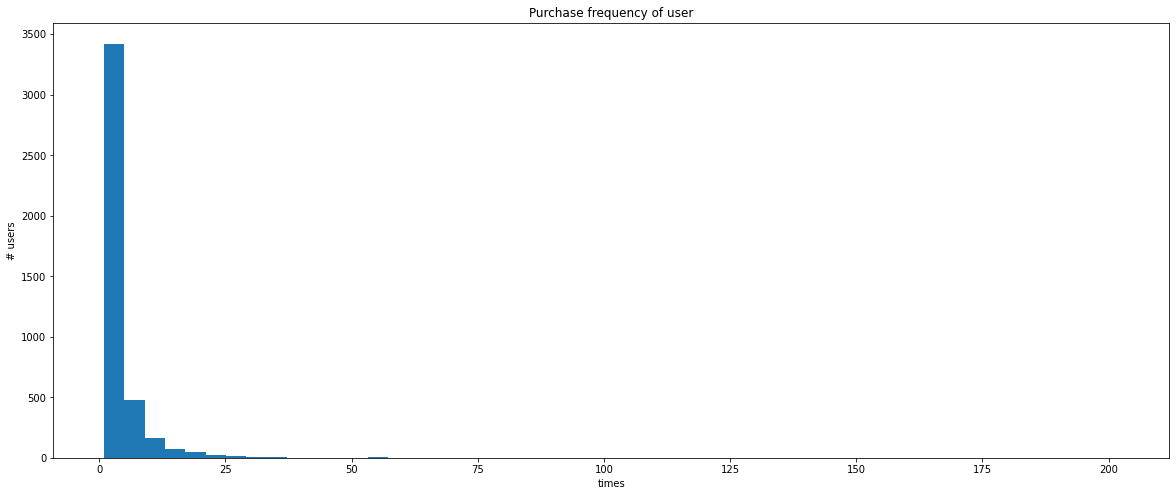

In [147]:
plt.figure(figsize=(20,8))
plt.hist(freqs,bins=50);
plt.title('Purchase frequency of user')
plt.xlabel('times')
plt.ylabel('# users')
pd.Series(freqs).describe(percentiles=[.35,.4,.5,.6,.75,.8,.95])

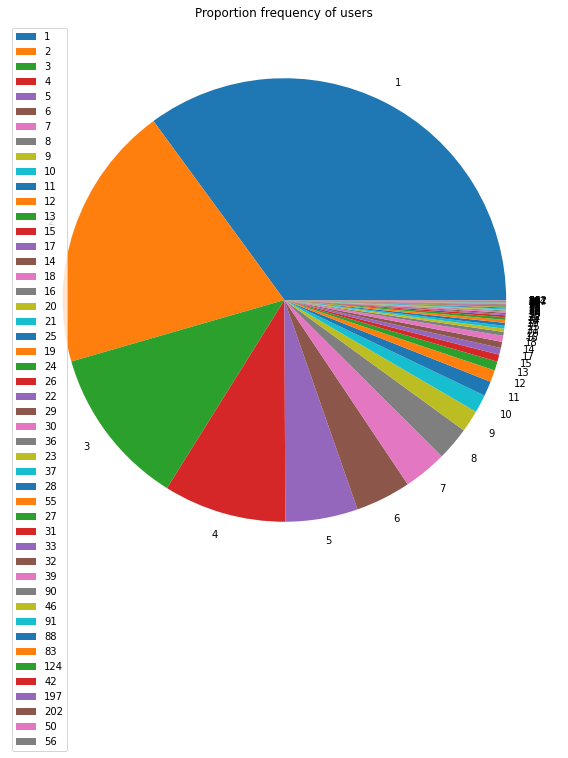

In [159]:
plt.figure(figsize=(20,8))
plt.pie(pd.Series(freqs).value_counts(),labels=pd.Series(freqs).value_counts().index);
plt.tight_layout()
plt.title('Proportion frequency of users')
plt.legend()

35% users are new users


In [219]:
user_num_item_bought=df_final.groupBy('user_id').agg(
    F.countDistinct('item_id').alias('num_item_bought')
).select('user_id','num_item_bought')

In [225]:
user_num_item_bought.join(df_freq_per_users,on='user_id').select(F.sum('num_item_bought'))

sum(num_item_bought)
247343


In [227]:
df_final.select('user_id').distinct().count()*df_final.select('item_id').distinct().count()

13603246

In [229]:
247343/13603246
# This is ~ netflix sparity ==> can do collaborative filtering


0.018182645524457912

In [215]:
df_rating_pd=df_final.withColumn('score',F.lit(1)).select('user_id','item_id','score').drop_duplicates().toPandas()

In [216]:
df_rating_pd.to_csv('/home/locnt7/files/data_rating_vnpay.csv',index=False)

Recommendation system will contain 3 segments :
- New users: Users just enter system, have no data
  - Enter system: Recommend most popular item
  - Search item: Session based + Content based 
- Warm start users: Users with little information about their previous preference: 
  - Association rule based on their last purchased items when open app
  - Search item: Session based + Content based 
- Old users: Users with dense trasaction on system:
  - Collaborative filtering when open app
  - Search item: Collaborative filtering + Content based 

When new item is added:
- Add to list item can be found by content based method
- When there are enough user buy this item will retrain cf model  

In [173]:
df_item_pd=df_item.toPandas()

In [40]:
df_final_pd.groupby('item_id').agg({
    'user_id':pd.Series.nunique
    }
).rename(columns={'user_id':'num_distinct_user'}).sort_values(['num_distinct_user'],ascending=False).reset_index()

,item_id,num_distinct_user
0,470883,806
1,1787583,768
2,1787079,764
3,998886,693
4,1782459,663
...,...,...
3189,787311,1
3190,1892184,1
3191,1892142,1
3192,1780233,1


In [81]:
dt=datetime(2022,9,1)
window=Window.partitionBy('user_id').orderBy(F.desc('timestamp'))

In [82]:
dt

datetime.datetime(2022, 9, 1, 0, 0)

In [83]:
df_latest_trans=df_final.filter(F.col('timestamp')<dt)\
    .groupBy('user_id','trans_id','timestamp').agg(
        F.collect_set('item_id').alias('package')
    )\
    .withColumn('order_trans_inverse',F.row_number().over(window))\
    .filter(F.col('order_trans_inverse')==1)

In [84]:
df_latest_trans.cache()

user_id,trans_id,timestamp,package,order_trans_inverse
268695,6353798,2019-02-02 06:27:00,"[486633, 484764, ...",1
272391,6389702,2019-02-17 08:20:00,"[454041, 488607, ...",1
280602,6377239,2019-02-11 10:41:00,"[493479, 438207, ...",1
291417,6234305,2018-11-26 11:49:00,"[489867, 455028]",1
291501,6263488,2018-12-16 05:26:00,[1785672],1
296688,6273223,2018-12-22 08:00:00,"[474117, 472143, ...",1
306768,6387887,2019-02-16 12:52:00,"[466347, 1764609,...",1
310296,6291076,2018-12-31 11:34:00,[440475],1
318927,6394597,2019-02-19 07:56:00,"[491148, 482832, ...",1
327642,6380836,2019-02-12 10:14:00,"[458010, 465234, ...",1


## Content based

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')


In [178]:
tfidf_matrix = tfidf.fit_transform(df_item_pd['description'])


In [183]:
from sklearn.metrics.pairwise import linear_kernel


In [184]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [200]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [203]:
linear_kernel(tfidf.transform(['adsf zxcv']),tfidf_matrix)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [204]:
a=np.array([2,1,3,4])

In [208]:
a.argsort()[::-1][:2]

array([3, 2])

In [210]:
df_item_pd.iloc[[2,4,1]]

,item_id,cost,description
2,455910,6.840000,folding umbrella pinkwhite polkadot
4,477099,1.653529,gumball monochrome coat rack
1,455112,1.730000,white spot red ceramic drawer knob


In [211]:
df_item_pd.to_csv('/home/locnt7/files/data_item_vnpay.csv',index=False)

In [234]:
df_final.groupBy('user_id','trans_id').agg(
    F.countDistinct('item_id').alias('num_items')
)

user_id,trans_id,num_items
261954,6342677,40
272391,6317630,3
270690,6342886,77
313131,6163300,61
287574,6169713,12
345954,6264731,75
293853,6090348,15
354837,5968611,30
326172,6180735,52
281274,6284410,25


In [241]:
df_package=df_final.groupBy('user_id','trans_id').agg(
    F.collect_set('item_id').alias('items')
).cache()

In [242]:
from pyspark.ml.fpm import FPGrowth,FPGrowthModel

In [244]:
fp=FPGrowth(minConfidence=0.001,minSupport=0.001,itemsCol='items')

In [245]:
model=fp.fit(df_package)

In [248]:
model.save("hdfs://10.60.37.61:8020/zalopay/data_platform/data_science/study/transaction_fpgrowth")

In [252]:
model.write().overwrite().save('hdfs://10.60.37.61:8020/zalopay/data_platform/data_science/study/transaction_fpgrowth')

In [253]:
model_=FPGrowthModel()

In [254]:
model_.load('hdfs://10.60.37.61:8020/zalopay/data_platform/data_science/study/transaction_fpgrowth')

FPGrowthModel: uid=FPGrowth_ebff62b4996c, numTrainingRecords=17398

In [246]:
model

FPGrowthModel: uid=FPGrowth_ebff62b4996c, numTrainingRecords=17398

In [247]:
model.transform(df_package)

user_id,trans_id,items,prediction
281274,6284410,"[474117, 470358, ...","[474138, 487158, ..."
283941,6395455,"[755370, 486024, ...","[487158, 489573, ..."
354837,5968611,"[451164, 740061, ...","[476406, 476259, ..."
374661,6308456,"[466452, 476259, ...","[435246, 470631, ..."
382158,6387469,"[476070, 456078, ...","[484029, 484071, ..."
382746,6239090,"[487242, 486465, ...","[487305, 475881, ..."
261954,6342677,"[462567, 481740, ...","[490413, 487158, ..."
268338,6352214,"[435099, 435183, ...","[460593, 434931, ..."
280119,6095364,"[470967, 479787, ...","[476679, 477120, ..."
313131,6163300,"[339276, 1890630,...","[474810, 474789, ..."


In [1]:
import sys

In [2]:
sys.path.append('/home/locnt7/interview/')

In [7]:
from recommender.AssociationRule import FpGrowthRecommender
from recommender.CollaborativeFilteringRec import CollaborativeFilteringRecommender
from recommender.ContentBasedRec import ContentBasedRecommender

In [90]:
df_final.groupBy('user_id').agg(
    F.countDistinct('trans_id').alias('count_trans')
).filter()

user_id,count_trans
296688,2
272391,82
327642,9
291501,6
318927,13
310296,11
352674,10
351267,1
351750,5
291417,1
